### Load data

In [ ]:
import os
import pandas as pd
import re

In [ ]:
def get_text(path):
    with open(path) as f:
        data = f.read()
    return data



path_train_neg = '../res/aclImdb/train/neg/'
path_train_pos = '../res/aclImdb/train/pos/'

train = [{'Class': 0, 'text': get_text(path_train_neg + x), } for x in os.listdir(path_train_neg)]\
+ [{'Class': 1, 'text': get_text(path_train_pos + x)} for x in os.listdir(path_train_pos)]


path_test_neg = '../res/aclImdb/test/neg/'
path_test_pos = '../res/aclImdb/test/pos/'


test = [{'Class': 0, 'text': get_text(path_test_neg + x), } for x in os.listdir(path_test_neg)]\
+ [{'Class': 1, 'text': get_text(path_test_pos + x)} for x in os.listdir(path_test_pos)]

In [ ]:
df = pd.DataFrame(train)
# df = df.sample(500)


In [ ]:
from nltk import word_tokenize


def preprocess_reviews(reviews):
    reviews = re.sub("(<br\s*/><br\s*/>)|(\-)|(\/)", ' ', reviews)
    return " ".join(reviews.split())

df.text = df.text.apply(preprocess_reviews)
df['tokenize'] = df.text.apply(word_tokenize)


In [ ]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords


wnl = WordNetLemmatizer()
def lemmatizer(tokens):
    res = []
    for token in tokens:
        token = re.sub("[\W\d]", '', token.lower())
        if token not in stopwords.words('english') and token != '':
            if wnl.lemmatize(token, pos='v') == token:
                res.append(wnl.lemmatize(token, pos='n'))
            else:
                res.append(wnl.lemmatize(token, pos='v'))
        else:
            continue
    return res

df['clean_review'] = df.tokenize.apply(lemmatizer, )
df.to_json('data.json')

In [1]:
import pandas as pd

df = pd.read_json('data.json', )
df['clean_review'] = df.clean_review.apply(' '.join)
df.head()

,Class,text,tokenize,clean_review
0,0,Working with one of the best Shakespeare sourc...,"[Working, with, one, of, the, best, Shakespear...",work one best shakespeare source film manage c...
1,0,"Well...tremors I, the original started off in ...","[Well, ..., tremors, I, ,, the, original, star...",well tremor original start find movie quite en...
10,0,"I felt brain dead, I'll tell you. This is the ...","[I, felt, brain, dead, ,, I, 'll, tell, you, ....",felt brain dead tell worst film ever buy ignor...
100,0,"Really an amazing pile of pap! A predictable, ...","[Really, an, amazing, pile, of, pap, !, A, pre...",really amaze pile pap predictable slow move so...
1000,0,"From everything I'd read about the movie, I wa...","[From, everything, I, 'd, read, about, the, mo...",everything read movie excite support film chri...


In [2]:
from sklearn.model_selection import train_test_split
x = df.clean_review
y = df.Class
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)

### Term 

In [3]:
from nltk import word_tokenize
from collections import Counter

def get_top_terms(reviews, n):
    res = []
    for i in reviews:
        tokens = word_tokenize(i)
        res.extend(tokens)
    res = Counter(res)
    return res.most_common(n)

neg = list(df[(df.Class == 1)]['clean_review'])
pos = list(df[(df.Class == 0)]['clean_review'])

top_negative_terms = pd.DataFrame.from_records(get_top_terms(neg, 30), columns=['word', 'freq'])
top_positive_terms = pd.DataFrame.from_records(get_top_terms(pos, 30), columns=['word', 'freq'])



In [4]:
from matplotlib import pyplot as plt

top_negative_terms.plot(kind='barh', x='word', figsize=(10,30))

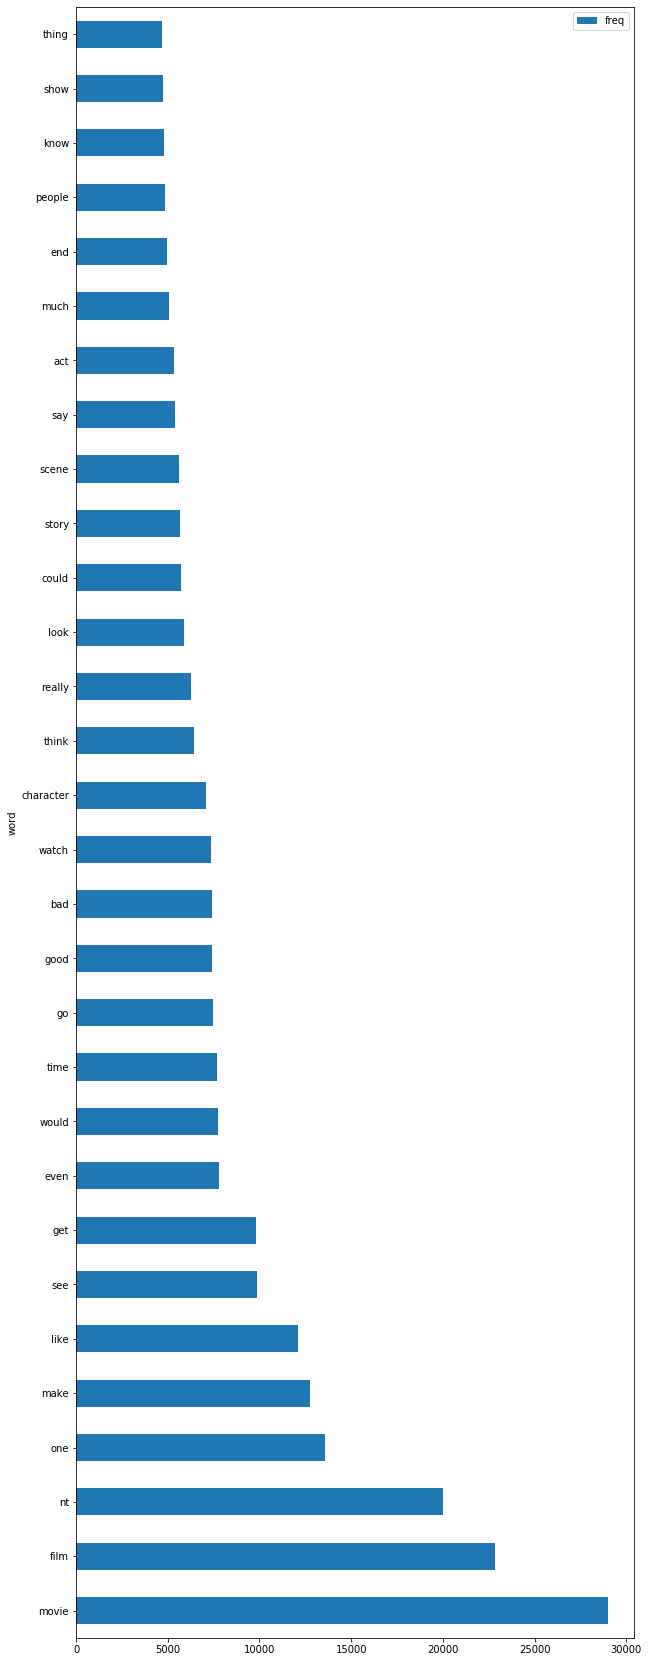

In [5]:
top_positive_terms.plot(kind='barh', x='word', figsize=(10,30))

In [6]:
from nltk.corpus import stopwords
stop_words = list((set(top_negative_terms.word) & set(top_positive_terms.word))|set(stopwords.words('english')))

### Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np

nb = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())
              ])

nb.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8320888888888889
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     11220
           1       0.86      0.79      0.83     11280

    accuracy                           0.83     22500
   macro avg       0.83      0.83      0.83     22500
weighted avg       0.83      0.83      0.83     22500



In [22]:
grid_params = {
    'clf__alpha': np.linspace(1e-4, 1e+5, 8),
    'clf__fit_prior': [True, False],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(1000, 5000, 5, dtype = np.int)
}


clf = GridSearchCV(nb, grid_params, cv = 5, verbose= True, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  5.5min finished


Best Score:  0.8304
Best Params:  {'clf__alpha': 0.0001, 'clf__fit_prior': False, 'vect__max_features': 1000, 'vect__ngram_range': (1, 2)}


In [23]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import FunctionTransformer


nb = Pipeline([('vect', CountVectorizer(max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', ComplementNB())
              ])

nb.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score
y_pred = nb.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8305777777777777
              precision    recall  f1-score   support

           0       0.81      0.86      0.84     11220
           1       0.85      0.80      0.83     11280

    accuracy                           0.83     22500
   macro avg       0.83      0.83      0.83     22500
weighted avg       0.83      0.83      0.83     22500



In [24]:
grid_params = {
    'clf__alpha': np.linspace(1e-4, 1e+5, 8),
    'clf__fit_prior': [True, False],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(1000, 5000, 5, dtype = np.int),
}

clf = GridSearchCV(nb, grid_params, cv = 5, verbose= True, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  5.6min finished


Best Score:  0.8304
Best Params:  {'clf__alpha': 0.0001, 'clf__fit_prior': True, 'vect__max_features': 1000, 'vect__ngram_range': (1, 2)}


## SGDClassifier

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

sgdc = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier())
              ])

sgdc.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score
y_pred = sgdc.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.8210222222222222
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     11220
           1       0.82      0.83      0.82     11280

    accuracy                           0.82     22500
   macro avg       0.82      0.82      0.82     22500
weighted avg       0.82      0.82      0.82     22500



In [26]:
sgdc.get_params()

grid_params = {
    'clf__alpha':  np.linspace(1e-4, 1e+5, 8),
    'clf__penalty': ['l2', 'l1'],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(1000, 5000, 5, dtype = np.int),
}

clf = GridSearchCV(sgdc, grid_params, cv = 3, verbose= True, n_jobs = -1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 3 folds for each of 160 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.1min finished


Best Score:  0.8176
Best Params:  {'clf__alpha': 0.0001, 'clf__penalty': 'l1', 'vect__max_features': 5000, 'vect__ngram_range': (1, 1)}


In [27]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1), max_features = 5000, stop_words = stop_words)),
               ('tfidf', TfidfTransformer()),
               ('clf', SVC(max_iter = 5000, kernel = 'rbf'))
              ])

svm.fit(x_train, y_train)


from sklearn.metrics import classification_report, accuracy_score
y_pred = svm.predict(x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy 0.49866666666666665
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     11220
           1       0.00      0.00      0.00     11280

    accuracy                           0.50     22500
   macro avg       0.25      0.50      0.33     22500
weighted avg       0.25      0.50      0.33     22500



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
svm.get_params()

grid_params = {
    
    'clf__C':  np.linspace(1e-4, 1e+5, 8),
    'clf__kernel':  ['sigmoid', 'linear', 'poly', 'rbf'],
    'clf__degree': [2, 3],
    'clf__max_iter': [5000],
    'clf__gamma': ['scale', 'auto'],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': np.linspace(1000, 5000, 5, dtype = np.int)
    
}

clf = GridSearchCV(svm, grid_params, cv = 3, verbose= True, n_jobs=-1)
clf.fit(x_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 56.4min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed: 68.4min finished


Best Score:  0.8408
Best Params:  {'clf__C': 14285.71437142857, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__max_iter': 5000, 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}


- Лучше всего себя покзаал SVM класификатор
- В качетсве стоп слов использовалось пересечения множетсва полпулярных нег. и позит. терминов вместе с стандартными набором английских стоп слов
- Помимо самих терминов использовались биграмы 
____
`
Best Score:  0.8408
Best Params:  
'clf__C': 14285.71437142857, 
'clf__degree': 2, 
'clf__gamma': 'scale', 
'clf__kernel': 'rbf', 
'clf__max_iter': 5000, 
'vect__max_features': 5000, 
'vect__ngram_range': (1, 2)
`